# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.8.0


In [ ]:
# Подключение к Kaggle через Kaggle API реализуем с помощью API Token:
# https://www.kaggle.com/general/74235
# Easiest way to download kaggle data in Google Colab

! pip install -q kaggle

In [ ]:
# импортирую свой Kaggle API Token
from google.colab import files

# Choose the kaggle.json file  (Kaggle API Token)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dalekseevspb","key":"38188f2ba4f8bf109236716c8160f6fd"}'}

In [ ]:
#  Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# That's all! You can check if everything's okay by running this command
# (список датасетов с Kaggle)
! kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36           1195        781  0.9375           
datasets/muratkokludataset/rice-image-dataset                                  Rice Image Dataset                               219MB  2022-04-03 02:12:00           1267        726  0.875            
datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           4423        110  1.0              


In [ ]:
# Download required dataset from Kaggle
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring

100% 2.11G/2.11G [00:11<00:00, 209MB/s]
100% 2.11G/2.11G [00:11<00:00, 203MB/s]


In [ ]:
!unzip the-nature-conservancy-fisheries-monitoring.zip

Archive:  the-nature-conservancy-fisheries-monitoring.zip
  inflating: sample_submission_stg1.csv.zip  
  inflating: sample_submission_stg2.csv.zip  
  inflating: test_stg1.zip           
  inflating: test_stg2.7z            
  inflating: train.zip               


In [ ]:
!unzip test_stg1.zip

In [ ]:
!unzip train.zip

In [ ]:
!pip install py7zr

In [ ]:
!py7zr x test_stg2.7z

In [ ]:
import os
print(os.listdir("../content"))

['.config', 'sample_submission_stg1.csv.zip', 'the-nature-conservancy-fisheries-monitoring.zip', 'test_stg2.7z', 'sample_submission_stg2.csv.zip', 'test_stg1', 'test_stg1.zip', '__MACOSX', 'train.zip', 'kaggle.json', 'train', 'test_stg2', 'sample_data']


# Загружаем разметку

In [74]:
import json
from glob import glob

TRAIN_PREFIX = '../content/train'

# предварительно файлы с описанием разметки (*_labels.json) должны быть загружены в каталог /boxes

def load_annotations():
    boxes = dict()
    for path in glob('../content/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        print(label)
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                    rect['class'] = label
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=12)
            img = cv2.putText(img.copy(), annotation['annotations'][i]['class'], tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img
    
    def __draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=2)
            img = cv2.putText(img.copy(), counts['class'][int(rect['label'])] + ': ' + str(rect['label']), tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = __draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [54]:
boxes = load_annotations()  # загружаем разметку детекций

alb
yft
lag
shark
dol
bet


In [57]:
# зафиксируем перечень классов, чтобы при загрузке разметки (json) нумерация классов была всегда одинакова (не сбивалась)
counts = pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count']).sort_values(by='count', ascending=False).reset_index()
counts.drop(columns='index', inplace=True)
counts

class  count
0    alb   1719
1    yft    734
2    bet    200
3  shark    176
4    dol    117
5    lag     67

In [58]:
fish_classes = counts['class'].values
fish_classes

array(['alb', 'yft', 'bet', 'shark', 'dol', 'lag'], dtype=object)

In [ ]:
# Легенда классификации рыб будет выглядеть так:
# class 0: alb - Albacore tuna 
# class 1: yft - Yellowfin tuna
# class 2: bet - Bigeye tuna
# class 3: shark - Sharks
# class 4: dol - Dolphinfish (Mahi Mahi)
# class 5: lag - Opah, Moonfish (Lamprus Guttatus)

# Остальные классы - без разметки:
# nof - No Fishes (на фото нет никаких рыб)
# oth - Other Fishes (на фото другие рыбы, не относящиеся ни к одному из вышеперечисленных классов)

{'annotations': [{'class': 'alb', 'height': 151.06975503141317, 'width': 383.68430384213445, 'x': 739.0000000000025, 'y': 268.8946201973347}], 'class': 'image', 'filename': '../content/train/ALB/img_07917.jpg'}


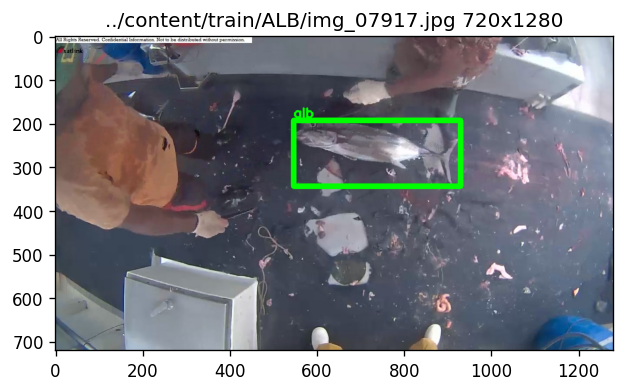

In [75]:
from matplotlib import pyplot as plt

annotation = boxes['alb'][0]
print(annotation)
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

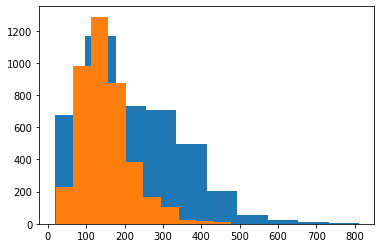

In [60]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [64]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [65]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [ ]:
num_classes = counts.shape[0]
num_classes

6

In [47]:
from scipy.special import softmax

def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        label = fish_classes == rect['class']
                
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]
            
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = np.array([*label, 1., dx, dy, dw, dh])

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            
            label = np.empty(6)
            # заполняем предсказанные вероятности каждого из 6-и классов в поля 'label'
            label[0], label[1], label[2], label[3], label[4], label[5], conf, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(conf)
            label = softmax(label)

            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(label)),
                                   'labels': label })
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

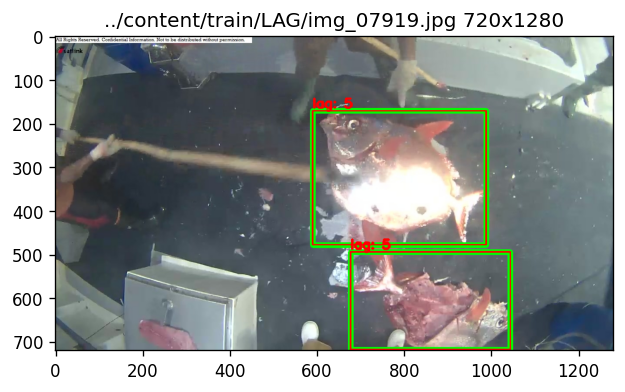

In [76]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [ ]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 6], 
                                      y_pred[..., 6],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., -4:] - y_pred[..., -4:])
    square_loss = 0.5 * K.square(y_true[..., -4:] - y_pred[..., -4:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_tr, y_pr, alpha=0.25, gamma=2.0):
  
    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_true, logits=y_pred)
    
    probs = tf.nn.softmax(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), alpha, (1.0 - alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, gamma) * cross_entropy
    
    return tf.reduce_sum(loss, axis=-1)

def class_loss(y_tr, y_pr):
    
    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]
    
    cross_entropy = K.categorical_crossentropy(y_true[..., :6], 
                                               y_pred[..., :6],
                                               from_logits=True)

    return cross_entropy

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))
    
    # TODO: добавьте функцию потерь для классификации детекции
    cls_loss = classification_loss(y_true, y_pred)
  
    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 6], axis=-1)
    pos_class_loss = K.sum(cls_loss * y_true[..., 6], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 6], axis=-1)
   
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 6], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 6]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    cls_loss = pos_class_loss / (num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss + cls_loss

## Загрузка данных

In [77]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                #print('boxes[j]', boxes[j])
                y_ = encode_anchors(boxes[j], img_shape)
                y.append(y_)
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [92]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции.
# Добавлено 6 выходов для классификации детекции 6-и классов (alb, bet, dol, lag, shark, yft).
# Вероятности классов 'Other Fishes' и 'No Fishes' возьмем из примера (sample_submission), они будут константами (не входят в выходы НС):
#  Oth: 0.079142
#  NoF: 0.123081

# Итого получилось 11 выходов: 
# - 6 классов (вероятности каждого из классов, рассчитанные по функции sоftmax)
# - 2 координаты x,y верхнего левого угла распознанного изображения
# - 2 величины смещения (высота, ширина) от координат верхнего левого угла распознанного изображения
# - 1 вероятность наличия распознанного изображения на картинке (по функции сигмоиды)

output = tf.keras.layers.Conv2D(11,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0   

## Обучение

In [93]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss, classification_loss, smooth_l1])

In [94]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10
  9/602 [..............................] - ETA: 5:56 - loss: 1.7972 - confidence_loss: 0.7434 - classification_loss: 0.2418 - smooth_l1: 0.3851
Epoch 1: loss improved from inf to 1.73033, saving model to fishdetector.hdf5
 19/602 [..............................] - ETA: 6:01 - loss: 1.5156 - confidence_loss: 0.7238 - classification_loss: 0.2452 - smooth_l1: 0.3752
Epoch 1: loss improved from 1.73033 to 1.49449, saving model to fishdetector.hdf5
 29/602 [>.............................] - ETA: 5:59 - loss: 1.3826 - confidence_loss: 0.6996 - classification_loss: 0.2376 - smooth_l1: 0.3701
Epoch 1: loss improved from 1.49449 to 1.37066, saving model to fishdetector.hdf5
 39/602 [>.............................] - ETA: 5:55 - loss: 1.2926 - confidence_loss: 0.6821 - classification_loss: 0.2303 - smooth_l1: 0.3608
Epoch 1: loss improved from 1.37066 to 1.28875, saving model to fishdetector.hdf5
 49/602 [=>............................] - ETA: 5:51 - loss: 1.2437 - confidence_loss: 0.

## Результат работы детектора

In [ ]:
# загружаем веса ранее обученной модели (чтобы не проводить повторное длительное обучение)
# model.load_weights('../content/fishdetector_11outputs.hdf5')

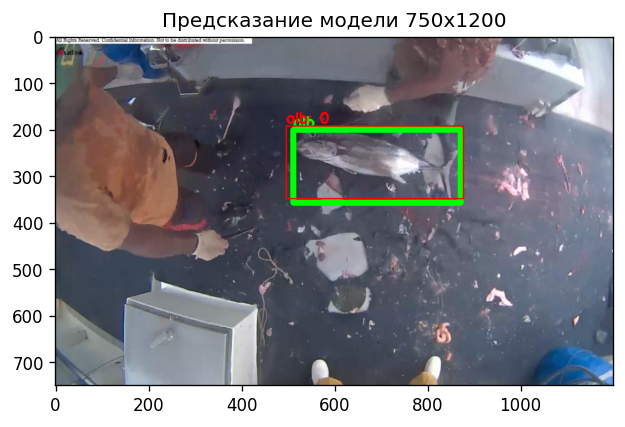

In [95]:
annotation = boxes['alb'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.15)

decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

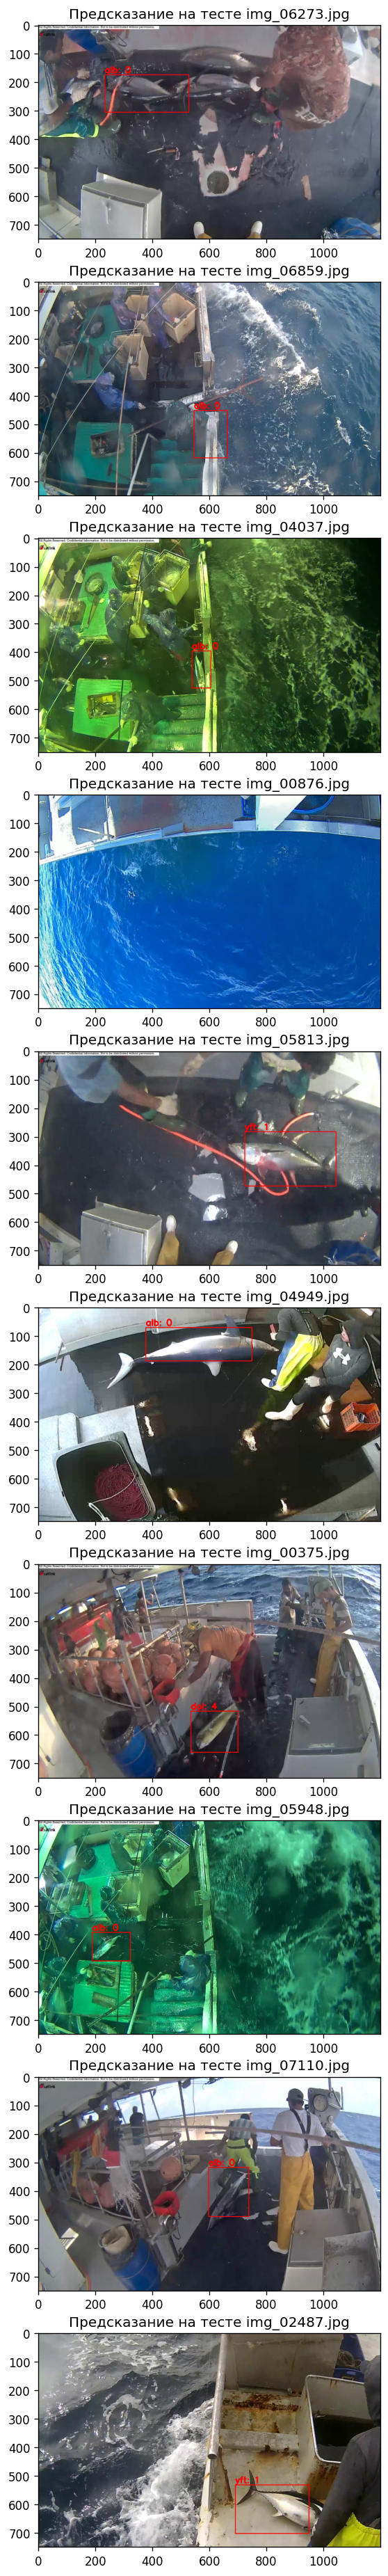

In [109]:
test_images = glob('../content/test_stg1/*.jpg')[:10]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)

    pred = model.predict(np.array([sample_img,]))
    decoded = decode_prediction(pred[0], conf_thr=0.01)
    decoded = non_max_suppression(decoded,
                                  max_output_size=1,
                                  iou_threshold=0.5)
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename.split('/')[-1]));

## Агрегация результатов

In [110]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

fish_classes

array(['alb', 'yft', 'bet', 'shark', 'dol', 'lag'], dtype=object)

In [ ]:
# При подготовке файла будем использовать зафиксированный ранее перечень классов, 
# при этом class 0 = decoded[0] = 'alb - Albacore tuna' и т.д.

# class 0: alb - Albacore tuna 
# class 1: yft - Yellowfin tuna
# class 2: bet - Bigeye tuna
# class 3: shark - Sharks
# class 4: dol - Dolphinfish (Mahi Mahi)
# class 5: lag - Opah, Moonfish (Lamprus Guttatus)

In [132]:
def make_predictions():
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])
    
    for i, file in enumerate(glob('../content/test_stg1/*.jpg')):
        bn = os.path.basename(file)
        # print(bn)
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.00)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        # print(decoded[0])

        decoded = decoded[0]['labels']

        ptable.loc[i, 'image'] = bn
        ptable.loc[i, 'ALB'] = decoded[0]
        ptable.loc[i, 'BET'] = decoded[2]
        ptable.loc[i, 'DOL'] = decoded[4]
        ptable.loc[i, 'LAG'] = decoded[5]
        ptable.loc[i, 'SHARK'] = decoded[3]
        ptable.loc[i, 'YFT'] = decoded[1]
        ptable.loc[i, 'NoF'] = 0.123081 # фиксированная вероятность для класса 'No Fishes' из файла sample_submission
        ptable.loc[i, 'OTHER'] = 0.079142 # фиксированная вероятность для класса 'Other Fishes' из файла sample_submission

    i += 1    
    
    for j, file in enumerate(glob('../content/test_stg2/*.jpg')):
        bn = os.path.basename(file)
        
        bn = "test_stg2/" + bn
        # print(bn)
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]

        decoded = decode_prediction(pred, conf_thr=0.00)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        
        decoded = decoded[0]['labels']

        ptable.loc[i + j, 'image'] = bn
        ptable.loc[i + j, 'ALB'] = decoded[0]
        ptable.loc[i + j, 'BET'] = decoded[2]
        ptable.loc[i + j, 'DOL'] = decoded[4]
        ptable.loc[i + j, 'LAG'] = decoded[5]
        ptable.loc[i + j, 'SHARK'] = decoded[3]
        ptable.loc[i + j, 'YFT'] = decoded[1]
        
        ptable.loc[i + j, 'NoF'] = 0.123081 # фиксированная вероятность для класса 'No Fishes' из файла sample_submission
        ptable.loc[i + j, 'OTHER'] = 0.079142 # фиксированная вероятность для класса 'Other Fishes' из файла sample_submission

    return ptable

**Готовим данные для отправки**

In [ ]:
pred_table = make_predictions()
pred_table.to_csv("submit.csv", index=False)
print(os.listdir("./"))

Выходные данные были обрезаны до нескольких последних строк (5000).
test_stg2/image_06692.jpg
test_stg2/image_04424.jpg
test_stg2/image_06108.jpg
test_stg2/image_09350.jpg
test_stg2/image_03797.jpg
test_stg2/image_01721.jpg
test_stg2/image_08723.jpg
test_stg2/image_11295.jpg
test_stg2/image_05183.jpg
test_stg2/image_10484.jpg
test_stg2/image_07601.jpg
test_stg2/image_02279.jpg
test_stg2/image_11559.jpg
test_stg2/image_07556.jpg
test_stg2/image_00175.jpg
test_stg2/image_09847.jpg
test_stg2/image_01070.jpg
test_stg2/image_08949.jpg
test_stg2/image_07777.jpg
test_stg2/image_00004.jpg
test_stg2/image_02607.jpg
test_stg2/image_07851.jpg
test_stg2/image_07387.jpg
test_stg2/image_09924.jpg
test_stg2/image_10362.jpg
test_stg2/image_02858.jpg
test_stg2/image_02930.jpg
test_stg2/image_00661.jpg
test_stg2/image_10249.jpg
test_stg2/image_02157.jpg
test_stg2/image_11308.jpg
test_stg2/image_09464.jpg
test_stg2/image_01105.jpg
test_stg2/image_02803.jpg
test_stg2/image_04353.jpg
test_stg2/image_08494.

In [90]:
pred_table

image       ALB       BET       DOL       LAG       NoF  \
0    img_06273.jpg  0.526452  0.081403  0.023497  0.056556  0.123081   
1    img_06859.jpg  0.222031  0.138415  0.100074  0.123497  0.123081   
2    img_04037.jpg  0.483608  0.129294  0.062712  0.059852  0.123081   
3    img_00876.jpg  0.522754   0.09958  0.072461  0.104671  0.123081   
4    img_05813.jpg  0.026969   0.03164  0.022374  0.032904  0.123081   
..             ...       ...       ...       ...       ...       ...   
995  img_03831.jpg  0.115716   0.18802  0.059991  0.039081  0.123081   
996  img_03588.jpg  0.101504  0.209711  0.097974    0.1343  0.123081   
997  img_04136.jpg  0.510451   0.19956  0.054976  0.097703  0.123081   
998  img_06003.jpg  0.495016   0.09188  0.054246  0.066688  0.123081   
999  img_04321.jpg  0.480919  0.120414  0.047909  0.053644  0.123081   

        OTHER     SHARK       YFT  
0    0.079142  0.065336  0.246756  
1    0.079142  0.124438  0.291546  
2    0.079142  0.236249  0.028284  
3    0.079142  0.079015  0.121519  
4    0.079142  0.040688  0.845425  
..        ...       ...       ...  
995  0.079142  0.064868  0.532325  
996  0.079142  0.095895  0.360618  
997  0.079142   0.05742  0.079889  
998  0.079142  0.075129  0.217042  
999  0.079142  0.132227  0.164886  

[1000 rows x 9 columns]